In [2]:
import os, subprocess

In [3]:
def make_input(input_dictionary):
    os.chdir("/Applications/CEA")
    filename = "rocket"+str(input_dictionary["case number"])+".inp"
    #return (input_dictionary["case number"],input_dictionary["OFratio"],input_dictionary["chamber-to-throat area ratio"],input_dictionary["chamber temperature"],input_dictionary["pressure ratio"],input_dictionary["fuel"],input_dictionary["oxidizer"])
    text = """problem   case={} o/f={},\n    rocket  fac   ac/at={}  tcest,k={}\n  p,psia={},\n  pi/p={},
react  \n  fuel={} moles=1.  t,k={}  \n  oxid={} moles=1.  \nonly \n  Ar C CO CO2 H H2 H2O HNO HO2 HNO2 HNO3 N NH NO N2 N2O3 O O2 OH O3 \noutput  massf transport \n    plot isp \nend"""
    text = text.format(input_dictionary["case number"],
                       input_dictionary["OFratio"],
                       input_dictionary["chamber-to-throat area ratio"],
                       input_dictionary["chamber temperature"],
                       input_dictionary["chamber pressure"],
                       input_dictionary["pressure ratio"],
                       input_dictionary["fuel"],
                       input_dictionary["fuel temperature"],
                       input_dictionary["oxidizer"])
    with open(filename,"w") as f:
        data = f.write(text)
    return filename
        
def runCEA(filename):
    filename_no_extension = filename.split('.inp')[0]
    p = subprocess.Popen(['FCEA2'], stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_data = p.communicate(input=filename_no_extension.encode('utf-8'))[0]
    return filename_no_extension+".out"
    
def extract_values(filename):
    output_dict = {}
    with open(filename) as f:
        text = f.read()
        #extract injector and chamber temperatures
        s = text.split("T, K")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["injector temperature"] = float(token)
                elif i == 2:
                    output_dict["chamber end temperature"] = float(token)
                    break
        #extract Ae/At
        s = text.split("Ae/At")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["throat-to-exit area ratio"] = float(token)
                    break
        #extract Cstar
        s = text.split("CSTAR, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["Cstar"] = float(token)
                    break
        #extract Ivac
        s = text.split("Ivac, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Ivac"] = float(token)
                    break
        #extract Isp
        s = text.split("Isp, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Isp"] = float(token)
                    break
        return output_dict
    
def runAll(input_dictionary):
    filename = make_input(input_dictionary)
    filename = runCEA(filename)
    return extract_values(filename)

In [4]:
input_dict = {"case number":2003,
              "OFratio":2.43,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3446,
              "chamber pressure":250,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
runAll(input_dict)

{'Cstar': 1805.7,
 'Isp': 2567.5,
 'Ivac': 2908.8,
 'chamber end temperature': 3366.14,
 'injector temperature': 3369.08,
 'throat-to-exit area ratio': 3.8352}

## Isp vs. O/F ratio

We assume a chamber pressure of 250 psi.

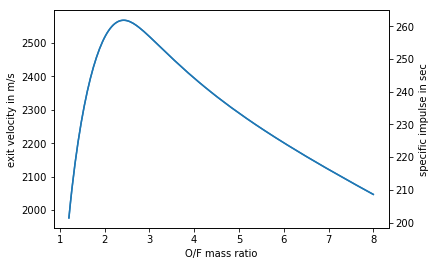

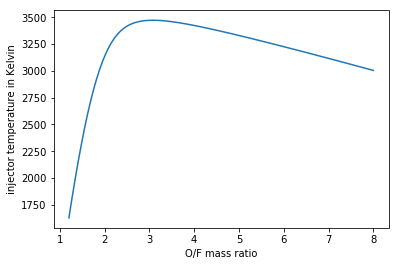

In [16]:
import matplotlib.pyplot as plt
import numpy as np


input_dict = {"case number":2003,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3000,
              "chamber pressure":250,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
OFratio = np.linspace(1.2,8.0,200)
Isp = []
Tc = []
for r in OFratio:
    input_dict["OFratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)
Tc = np.array(Tc)
fig, ax1 = plt.subplots()
ax1.plot(OFratio,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(OFratio,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("O/F mass ratio")
plt.show()

plt.plot(OFratio,Tc)
plt.xlabel("O/F mass ratio")
plt.ylabel("injector temperature in Kelvin")
plt.show()

This graph shows that a mass ratio of about 2.5 yields the maximum spcific impulse

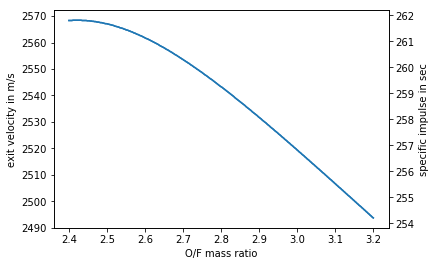

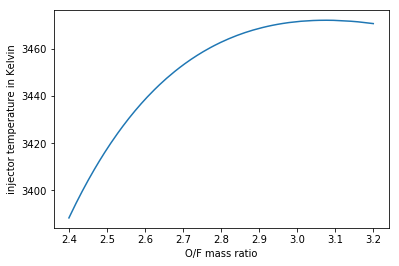

In [20]:
OFratio = np.linspace(2.4,3.2,300)
Isp = []
Tc = []
for r in OFratio:
    input_dict["OFratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)
Tc = np.array(Tc)
fig, ax1 = plt.subplots()
ax1.plot(OFratio,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(OFratio,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("O/F mass ratio")
plt.show()

plt.plot(OFratio,Tc)
plt.xlabel("O/F mass ratio")
plt.ylabel("injector temperature in Kelvin")
plt.show()

The peak of the temperature happens at about O/F ~ 3.0, but the performance peak occurs before that, at O/F=2.43. This value is almost a 100 K cooler than the peak temperature which is definitely a bonus. Therefore we're choosing a mass ratio of 2.43.

In [28]:
fuel_density = 0.726
oxidizer_density = 1.146
2.43*fuel_density/oxidizer_density

1.5394240837696338

## Isp vs. chamber-to-throat area ratio

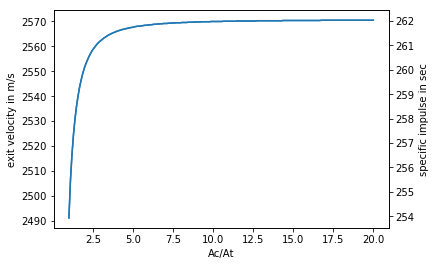

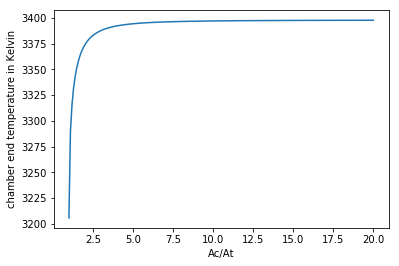

In [26]:
input_dict = {"case number":2003,
              "OFratio": 2.43,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3000,
              "chamber pressure":250,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
AcAt = np.linspace(1.0,20.0,200)
Isp = []
Tc = []
for r in AcAt:
    input_dict["chamber-to-throat area ratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["chamber end temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)
Tc = np.array(Tc)
fig, ax1 = plt.subplots()
ax1.plot(AcAt,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(AcAt,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("Ac/At")
plt.show()

plt.plot(AcAt,Tc)
plt.xlabel("Ac/At")
plt.ylabel("chamber end temperature in Kelvin")
plt.show()

Clearly the wider the chamber, the higher the performance will be, although improvements are minute after an area ratio of about ~5. Bigger chambers mean more area to cool which can significantly increase the weight of the engine or even prevent its feasibility altogether. Smaller ratios also have the advantage of enduring lower temperatures at the combustor's end, but since the temperature at the injector does is insentive to this ratio, the benefits of a lower temperature here do not outweigh the loss of specific impulse at ratios lower than 5.0 as would be required to significantly lower the end of the chamber's temperature.

## Isp vs. chamber pressure

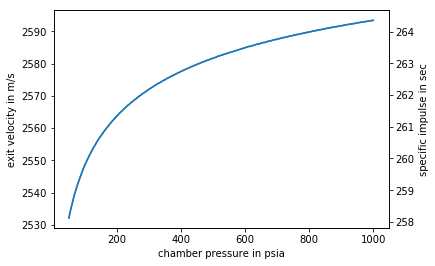

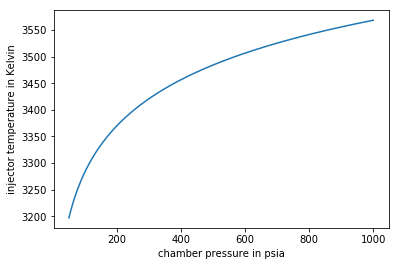

In [15]:
input_dict = {"case number":2003,
              "OFratio": 2.43,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":3000,
              "chamber pressure":250,
              "pressure ratio":20.4207459666,
              "fuel":"C8H18(L),n-octa",
              "fuel temperature":298,
              "oxidizer":"O2(L)"
             }
Pc = np.linspace(50,1000,300)
Isp = []
Tc = []
for p in Pc:
    input_dict["chamber pressure"] = p
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)
Tc = np.array(Tc)
fig, ax1 = plt.subplots()
ax1.plot(Pc,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(Pc,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("chamber pressure in psia")
plt.show()

plt.plot(Pc,Tc)
plt.xlabel("chamber pressure in psia")
plt.ylabel("injector temperature in Kelvin")
plt.show()

The engine's performance increases with the chamber's internal pressure. However, so does the temperature and of course the thickness of the walls, which means additional weight and technical difficulties. For those reasons, we will choose a chamber pressure of 250 psia.